In [60]:
with open('./share/common.py') as fin:
   exec(fin.read())

In [61]:
with open('./share/matplotlibconf.py') as fin:
    exec(fin.read())

In [62]:
data_file = "Output/wine_cleaned.csv"
df = pd.read_csv(data_file)

### check the size of data from 'description' and 'points'

In [63]:
df.count()

country                  129908
description              129908
points                   129908
price                    120916
province                 129908
region_1                 108724
taster_name              103664
taster_twitter_handle     98695
title                    129908
variety                  129907
winery                   129908
Wine_Year                129908
dtype: int64

#### Grouped by 'points' column, and check the distribution of 'description' over 'points' bin.

In [64]:
df_sub = df[['description', 'points']]
df_sub.groupby(['points']).count()

,description
points,
80,397
81,692
82,1835
83,3024
84,6478
...,...
96,523
97,229
98,77


### Plot the distribution of 21 different points values

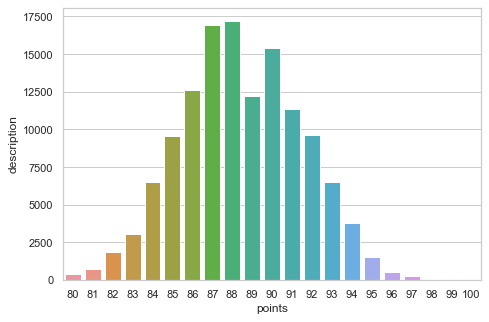

In [65]:
sns.set(style="whitegrid")
data = df_sub.groupby(['points']).count().reset_index()
sns.barplot(x='points', y='description', data=data)

### Description length vs Points

In [66]:
df_sub = df_sub.assign(description_len = df_sub['description'].apply(len))

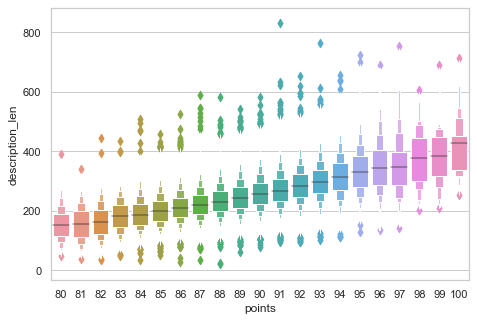

In [68]:
fig, ax = plt.subplots()
sns.set(color_codes=True)
sns.boxenplot(x='points', y='description_len', data=df_sub)

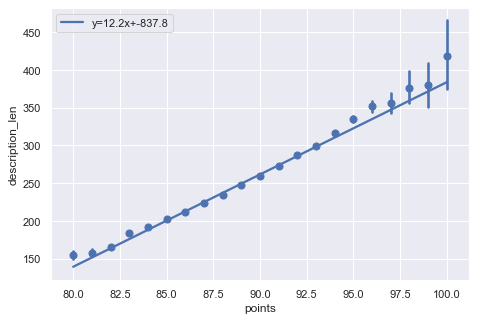

In [69]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['points'], df_sub['description_len'])
fig, ax = plt.subplots()
sns.set(color_codes=True)
ax = sns.regplot(x='points', y='description_len', data=df_sub, x_estimator=np.mean, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()

#### 5 different bins.  This is also a set up for clustering points into 5 different categories.

In [100]:
bins = [0, 83, 87, 91, 96, 100]
labels = [1, 2, 3, 4, 5]
df_sub['points_binned'] = pd.cut(df_sub['points'], bins=bins, labels=labels)
df_sub['points_binned'].value_counts()

3    56162
2    45529
4    21911
1     5948
5      358
Name: points_binned, dtype: int64

#### We can still see a similar trend.  As we have longer description, there is higher chance of hihger points.  

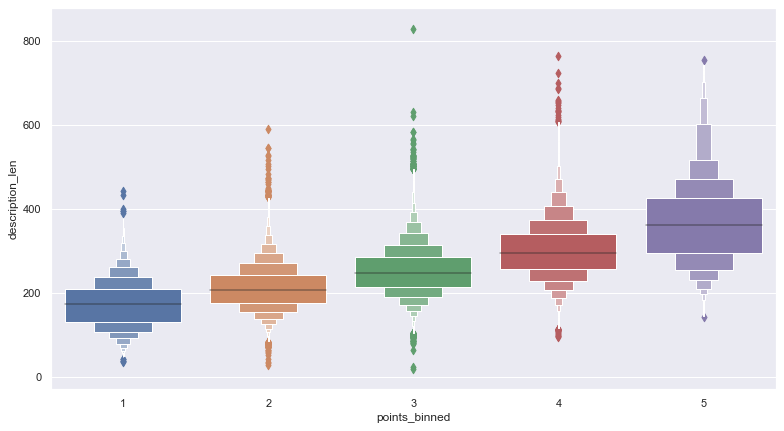

In [101]:
fig, ax = plt.subplots(figsize=(13,7))
sns.set(color_codes=True)
sns.boxenplot(x='points_binned', y='description_len', data=df_sub)

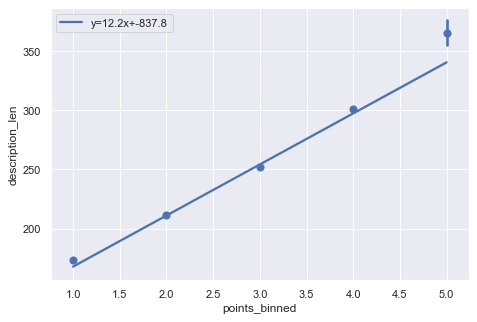

In [102]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['points'], df_sub['description_len'])
fig, ax = plt.subplots()
sns.set(color_codes=True)
ax = sns.regplot(x='points_binned', y='description_len', x_estimator=np.mean, data=df_sub, color='b', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()

In [105]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [106]:
df_p = df_sub[['description', 'points_binned']]
df_p.count()

description      129908
points_binned    129908
dtype: int64

In [107]:
X = df_p['description']
y = df_p['points_binned']
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(X)
X = vectorizer.transform(X)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
rfc = RandomForestClassifier()
h1 = rfc.fit(X_train, y_train)

In [109]:
pred = h1.predict(X_test)

In [110]:
target_names = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']
print(classification_report(y_test, pred, target_names=target_names, digits=4))

precision    recall  f1-score   support

     Score 1     0.9583    0.0778    0.1440       591
     Score 2     0.7105    0.7161    0.7133      4593
     Score 3     0.6147    0.8385    0.7094      5579
     Score 4     0.8693    0.2779    0.4212      2202
     Score 5     0.0000    0.0000    0.0000        26

    accuracy                         0.6639     12991
   macro avg     0.6306    0.3821    0.3976     12991
weighted avg     0.7061    0.6639    0.6348     12991



In [111]:
pickle.dump(h1, open('./models/h1.pkl', 'wb'))
pickle.dump(tfidf, open("./models/tifidf.pkl", "wb"))

#### End